In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import csv

In [2]:
data = pd.read_csv("D:\BU\BE700\project\data\HPA-Protein\lung.tsv", delimiter = '\t', header = None, usecols = [0,1])
data


,0,1
0,ENSG00000105483,ENSG00000171467
1,ENSG00000100030,ENSG00000261371
2,ENSG00000162385,ENSG00000169045
3,ENSG00000141458,ENSG00000184584
4,ENSG00000117724,ENSG00000197321
...,...,...
102367,ENSG00000138131,ENSG00000138190
102368,ENSG00000107581,ENSG00000135480
102369,ENSG00000094631,ENSG00000239713
102370,ENSG00000167900,ENSG00000196705


In [3]:
G = nx.from_pandas_edgelist(data, source = 0, target = 1)
nx.is_directed(G)

False

In [4]:
adj_mat = nx.to_numpy_matrix(G)
adj_mat

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
krogan_proteins = pd.read_excel("D:\BU\BE700\project\data\convert_unique.xlsx", usecols= [0])
krogan_proteins

,Gene stable ID
0,ENSG00000280759
1,ENSG00000228691
2,ENSG00000282003
3,ENSG00000224774
4,ENSG00000282230
...,...
327,ENSG00000198933
328,ENSG00000136485
329,ENSG00000154240
330,ENSG00000109062


In [73]:
nodes = list(G.nodes())
neighbors = {}
for gene in krogan_proteins['Gene stable ID']:
    if gene in nodes:
        neighbors[gene] = []
        for i in np.where(adj_mat[nodes.index(gene)] == 1)[1]:
            neighbors[gene].append(nodes[i])
            
# print(neighbors)

In [68]:
# with open('firstneighbors.csv', 'w') as csv_file:  
#     writer = csv.writer(csv_file)
#     for key, value in neighbors.items():
#         writer.writerow([key, value])

In [7]:
# create 4 matrix
from numpy.linalg import inv
dim = len(nodes)
degree = np.sum(adj_mat, axis = 0)
D = np.diag(degree.A1)
L = D - adj_mat
I = np.identity(dim)
K = inv(I + 0.1*L)
print('finish')

finish


In [8]:
y = np.zeros([dim,1])
for id in neighbors.keys():
    y[nodes.index(id)] = 1

In [9]:
y_hat = np.dot(K, y)

In [17]:
# create dataframe
y_hat = y_hat.A1
diffusion = {
'id': nodes,
'diffusion_value': y_hat   
}

df = pd.DataFrame(diffusion, columns = ['id', 'diffusion_value'])

In [19]:
# write dataframe
df.to_csv ('diffusion_score.csv', index = False, header=True)


In [22]:
sum(y_hat > 0.05)

335

In [ ]:
# 2nd protein to krogan ppi dictionary
sec_kro_ppi = {}
for k,v in neighbors.items():
    for x in v:
        neighbors.setdefault(x,[]).append(k)
        
len(sec_kro_ppi.keys())

# save to dictionary
j = json.dumps(sec_kro_ppi)
with open('sec_kro_ppi.json', 'w') as f:
    f.write(j)
    f.close()

In [6]:
##########################################################
# guilt by association
##########################################################
sec_kro_ppi = json.load(open('sec_kro_ppi.json'))

linked_krogan = []

for id in sec_kro_ppi.keys():
    linked_krogan.append(len(sec_kro_ppi[id]))
    
ids = list(sec_kro_ppi.keys())


In [7]:
len(linked_krogan)

2962

In [8]:
# create dataframe
guilt_by_association = {
'id': ids,
'linked_krogan': linked_krogan   
}

df = pd.DataFrame(guilt_by_association, columns = ['id', 'linked_krogan'])
df.to_csv ('guilt_by_association.csv', index = False, header=True)


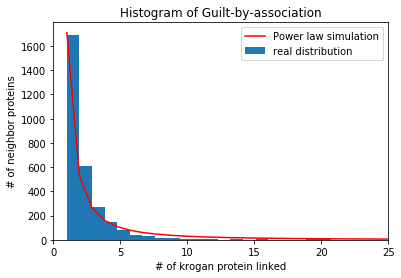

[1709.85814796   -1.76450973]


In [48]:
# plot distribution 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.figure()
# histogram
counts, bins, bars = plt.hist(linked_krogan, bins = 50, label = 'real distribution')
# fit power law
def func(x, k, a):
    return k * x**a

interval = bins[0:-1]
popt, pcov = curve_fit(func, x, y)
plt.plot(x, func(x, *popt), 'r-', label = 'Power law simulation')

plt.ylabel('# of neighbor proteins')
plt.xlabel('# of krogan protein linked')
plt.title('Histogram of Guilt-by-association')

plt.xlim((0, 25))
plt.legend()

plt.savefig('guilt_by_association.png')
plt.show()

print(popt)

In [16]:
thres = 4
protein_num = 0
for ii in linked_krogan:
    if ii >= thres:
        protein_num = protein_num + 1

print(protein_num)



1


In [48]:
# read diffusion and guilt-by-association, set threshold and export
diffusion = pd.read_csv("diffusion_score.csv")
gbs = pd.read_csv("guilt_by_association.csv")

above005 = diffusion[diffusion['diffusion_value'] >= 0.05]
above005.to_csv ('diffusion_threshold005.csv', index = False, header=True)
above4 = gbs[gbs['linked_krogan'] >= 4]
above4.to_csv('guilt_by_association_threshold4.csv', index = False, header = True)